In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [8]:
os.chdir('C:\\Users\\Hp\\OneDrive\\Documents\\GitHub\\Thoucentric\\DataSets')

In [9]:
df=pd.read_csv('Iceus_sugar_all.csv')
df

,date,low,high,close,open
0,2017-01-03T00:00:00.000Z,19.58,20.55,20.51,19.63
1,2017-01-04T00:00:00.000Z,20.41,20.94,20.89,20.55
2,2017-01-05T00:00:00.000Z,20.66,21.18,20.78,20.89
3,2017-01-06T00:00:00.000Z,20.30,20.84,20.75,20.66
4,2017-01-09T00:00:00.000Z,20.36,20.75,20.42,20.74
...,...,...,...,...,...
2067,2024-06-17T00:00:00.000Z,18.81,19.32,18.98,18.93
2068,2024-06-18T00:00:00.000Z,18.81,19.19,18.92,18.93
2069,2024-06-19T00:00:00.000Z,18.81,19.19,18.92,19.10
2070,2024-06-20T00:00:00.000Z,18.82,19.43,18.89,18.92


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2072 entries, 0 to 2071
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    2072 non-null   object 
 1   low     2072 non-null   float64
 2   high    2072 non-null   float64
 3   close   2072 non-null   float64
 4   open    2071 non-null   float64
dtypes: float64(4), object(1)
memory usage: 81.1+ KB


In [11]:
df.index=pd.to_datetime(df['date'], format='ISO8601')
df=df.drop(columns=['date',])
df.head()

,low,high,close,open
date,,,,
2017-01-03 00:00:00+00:00,19.58,20.55,20.51,19.63
2017-01-04 00:00:00+00:00,20.41,20.94,20.89,20.55
2017-01-05 00:00:00+00:00,20.66,21.18,20.78,20.89
2017-01-06 00:00:00+00:00,20.30,20.84,20.75,20.66
2017-01-09 00:00:00+00:00,20.36,20.75,20.42,20.74


In [12]:
def df_to_X_y(df, window_size):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [13]:
windowsize=5
X, y= df_to_X_y(df, windowsize)
X,y

(array([[[[19.58, 20.55, 20.51, 19.63]],
 
         [[20.41, 20.94, 20.89, 20.55]],
 
         [[20.66, 21.18, 20.78, 20.89]],
 
         [[20.3 , 20.84, 20.75, 20.66]],
 
         [[20.36, 20.75, 20.42, 20.74]]],
 
 
        [[[20.41, 20.94, 20.89, 20.55]],
 
         [[20.66, 21.18, 20.78, 20.89]],
 
         [[20.3 , 20.84, 20.75, 20.66]],
 
         [[20.36, 20.75, 20.42, 20.74]],
 
         [[20.15, 20.56, 20.48, 20.5 ]]],
 
 
        [[[20.66, 21.18, 20.78, 20.89]],
 
         [[20.3 , 20.84, 20.75, 20.66]],
 
         [[20.36, 20.75, 20.42, 20.74]],
 
         [[20.15, 20.56, 20.48, 20.5 ]],
 
         [[20.48, 20.89, 20.56, 20.55]]],
 
 
        ...,
 
 
        [[[19.27, 19.6 , 19.43, 19.49]],
 
         [[19.27, 19.6 , 19.43, 19.49]],
 
         [[19.27, 19.6 , 19.43, 19.32]],
 
         [[18.81, 19.32, 18.98, 18.93]],
 
         [[18.81, 19.19, 18.92, 18.93]]],
 
 
        [[[19.27, 19.6 , 19.43, 19.49]],
 
         [[19.27, 19.6 , 19.43, 19.32]],
 
         [[18.81, 19.32, 

In [14]:
X=X.reshape(X.shape[0], X.shape[1], X.shape[3])
X.shape, y.shape

((2067, 5, 4), (2067, 4))

In [15]:
X_train, y_train = X[:1800], y[:1800]
X_val, y_val = X[1800:1950], y[1800:1950]
X_test, y_test = X[1950:], y[1950:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1800, 5, 4), (1800, 4), (150, 5, 4), (150, 4), (117, 5, 4), (117, 4))

In [16]:
from keras.models import Sequential
from keras.layers import *
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

In [17]:
model = Sequential()
model.add(InputLayer((windowsize, X_train.shape[2])))  # (5, 4)
model.add(LSTM(64))
model.add(Dense(8, activation='relu'))
model.add(Dense(y_train.shape[1], activation='linear'))  # 15 features in the output
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17664     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 4)                 36        
                                                                 
Total params: 18,220
Trainable params: 18,220
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=110)

Epoch 1/110
57/57 [==============================] - 2s 11ms/step - loss: 253.9488 - root_mean_squared_error: 15.9358 - val_loss: 510.3645 - val_root_mean_squared_error: 22.5912
Epoch 2/110
57/57 [==============================] - 0s 3ms/step - loss: 208.6744 - root_mean_squared_error: 14.4456 - val_loss: 423.5181 - val_root_mean_squared_error: 20.5796
Epoch 3/110
57/57 [==============================] - 0s 4ms/step - loss: 144.4834 - root_mean_squared_error: 12.0201 - val_loss: 286.5519 - val_root_mean_squared_error: 16.9278
Epoch 4/110
57/57 [==============================] - 0s 3ms/step - loss: 78.4507 - root_mean_squared_error: 8.8572 - val_loss: 172.0428 - val_root_mean_squared_error: 13.1165
Epoch 5/110
57/57 [==============================] - 0s 3ms/step - loss: 37.7267 - root_mean_squared_error: 6.1422 - val_loss: 100.6945 - val_root_mean_squared_error: 10.0347
Epoch 6/110
57/57 [==============================] - 0s 3ms/step - loss: 15.7738 - root_mean_squared_error: 3.9716 - v

In [19]:
train_predictions = model.predict(X_train).flatten()
ytrain1= y_train.flatten()
train_results = pd.DataFrame(data = {'Train Predictions': train_predictions, 'Actuals': ytrain1})
train_results

57/57 [==============================] - 0s 1ms/step


,Train Predictions,Actuals
0,20.167982,20.15
1,20.608934,20.56
2,20.344135,20.48
3,20.448219,20.50
4,20.156221,20.48
...,...,...
7195,26.052660,26.24
7196,25.776649,25.95
7197,26.507238,26.85
7198,26.094416,26.73


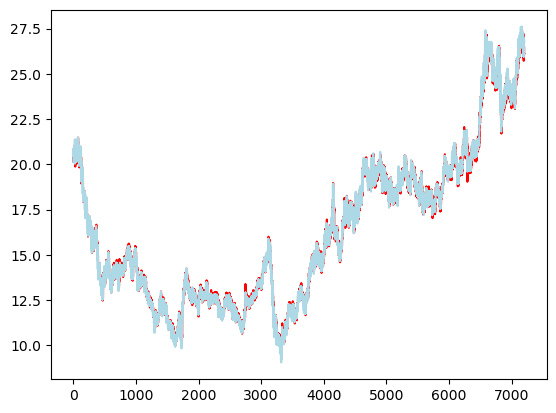

In [20]:
plt.plot(train_results['Train Predictions'][:], color= 'red')
plt.plot(train_results['Actuals'][:], color= 'lightblue')

In [21]:
val_predictions= model.predict(X_val).flatten()
y_val1=y_val.flatten()
val_results=pd.DataFrame(data={'Val Predictions': val_predictions, 'Val Actuals': y_val1})
val_results

5/5 [==============================] - 0s 2ms/step


,Val Predictions,Val Actuals
0,26.147820,26.20
1,26.930563,26.80
2,26.519299,26.27
3,26.462826,26.77
4,26.004791,26.20
...,...,...
595,22.605049,22.70
596,22.390972,22.56
597,22.916214,23.08
598,22.643251,22.62


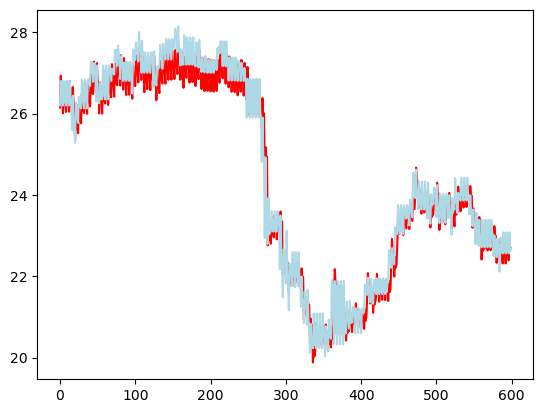

In [22]:
plt.plot(val_results['Val Predictions'][:], color='red')
plt.plot(val_results['Val Actuals'][:], color='lightblue')

In [23]:
test_predictions = model.predict(X_test).flatten()
ytest1=y_test.flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions, 'Test Actuals': ytest1})
test_results

4/4 [==============================] - 0s 1ms/step


,Test Predictions,Test Actuals
0,22.365788,22.45
1,22.881872,23.45
2,22.615721,23.15
3,22.657457,23.24
4,22.870897,23.12
...,...,...
463,19.017664,18.92
464,18.739607,18.81
465,19.179432,19.06
466,18.904566,18.97


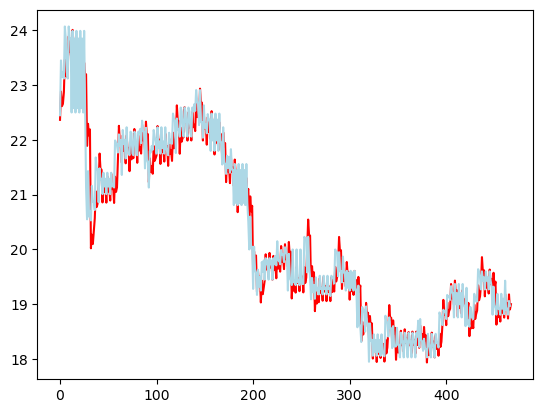

In [24]:
plt.plot(test_results['Test Predictions'][:], color='red')
plt.plot(test_results['Test Actuals'][:], color='lightblue')